In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from wrangle import *
from explore import *
from modeling import *

from scipy import stats
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

# Shhhh
import warnings
warnings.filterwarnings("ignore")

### Planning
##### Goal:
- Project Objective: Use Clusters to help advance our Regression Modeling attempts on the 2017 Zillow dataset.
##### Deliverables:
- Wrangle.py : Functions to reproduce Wrangling and Cleaning of Data.
- Explore.py : Functions to reproduce Exploring the Data.
- Model.py : Functions to reproduce Modeling the Data.
- Final Notebook (ipynb) : Notebook with steps to reproduce.
##### Questions to Explore:
- Which features have the most deviation from the logerror mean?
- Do any clusters help predict logerror?

------

### Data Acquisition and Data Preparations
Using our wrangle.py, we'll Acquire the data via the Cloud SQL and save a local copy as a .csv, any further need for data will load the local saved copy.

Outliers will be stripped, and the few remaining nulls dropped, as well as columns renamed for readability.

Histograms are generated to visualize our data,

Then the data will be split into Train, X_train, X_validate, X_test, y_train, y_validate, and y_test Dataframes.

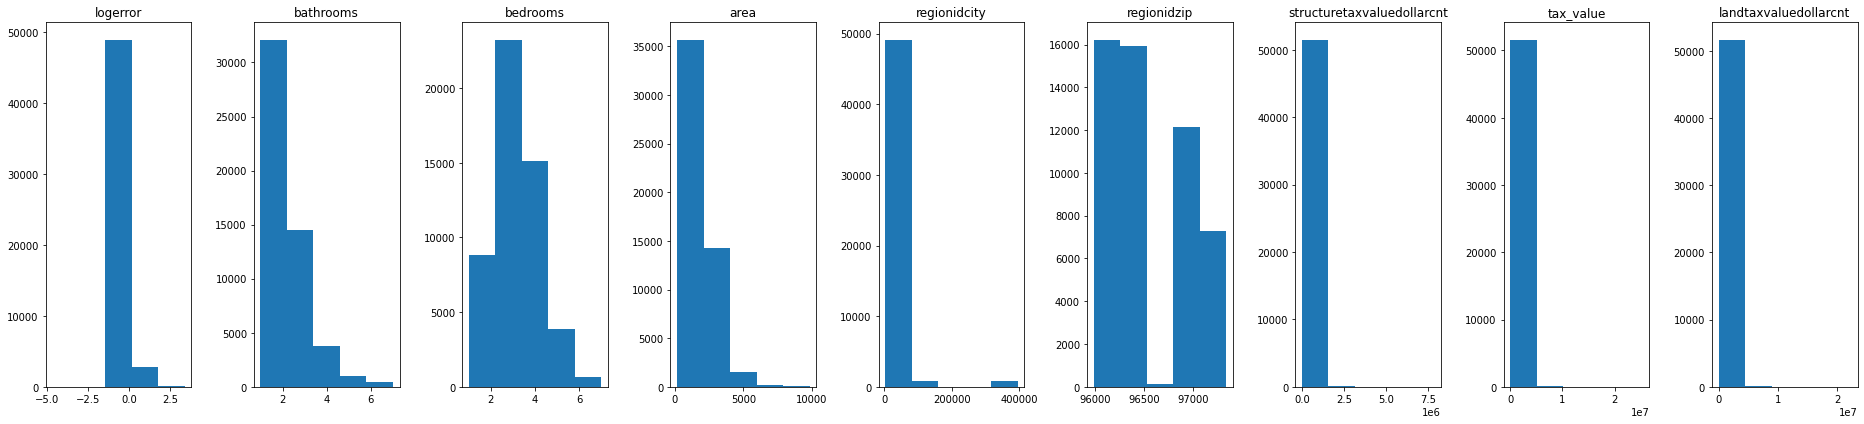

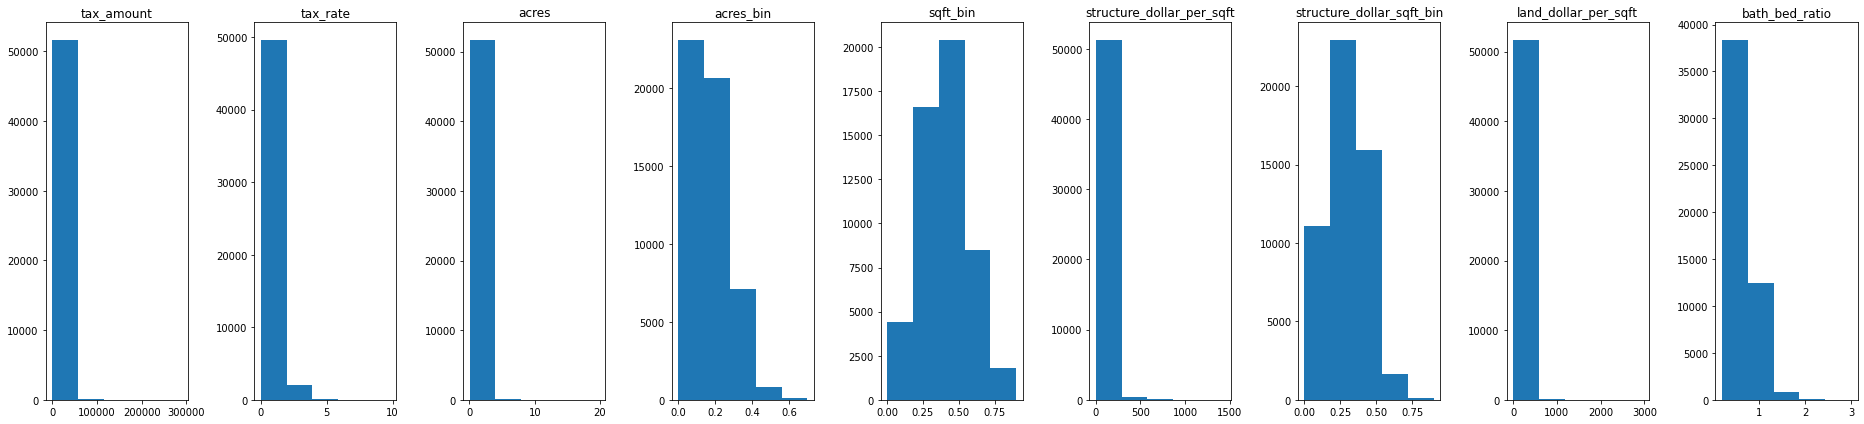

In [2]:
df = wrangle_zillow()

In [3]:
df.dtypes

parcelid                        int64
logerror                      float64
bathrooms                     float64
bedrooms                      float64
area                          float64
fips                          float64
latitude                      float64
longitude                     float64
lotsizesquarefeet             float64
regionidcity                  float64
regionidzip                   float64
yearbuilt                     float64
structuretaxvaluedollarcnt    float64
tax_value                     float64
landtaxvaluedollarcnt         float64
tax_amount                    float64
LA                              uint8
Orange                          uint8
Ventura                         uint8
age                           float64
age_bin                       float64
tax_rate                      float64
acres                         float64
acres_bin                     float64
sqft_bin                      float64
structure_dollar_per_sqft     float64
structure_do

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 0 to 52441
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    51736 non-null  int64  
 1   logerror                    51736 non-null  float64
 2   bathrooms                   51736 non-null  float64
 3   bedrooms                    51736 non-null  float64
 4   area                        51736 non-null  float64
 5   fips                        51736 non-null  float64
 6   latitude                    51736 non-null  float64
 7   longitude                   51736 non-null  float64
 8   lotsizesquarefeet           51736 non-null  float64
 9   regionidcity                50760 non-null  float64
 10  regionidzip                 51736 non-null  float64
 11  yearbuilt                   51708 non-null  float64
 12  structuretaxvaluedollarcnt  51678 non-null  float64
 13  tax_value                   517

Our Histograms look good with a few expected smaller outliers. All Datatypes are what might be expected and are easily worked with as well.
We do have a few nulls, given the small amount just dropping them shouldn't hurt. Also there's so many different features, we'll focus in on house attributes and vlues instead of locations. We'll also split to prepare for Exploration.

In [5]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = clean_and_split(df)
train.shape, X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((28378, 21),
 (28378, 20),
 (12163, 20),
 (10136, 20),
 (28378, 1),
 (12163, 1),
 (10136, 1))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28378 entries, 29916 to 40147
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   parcelid                   28378 non-null  int64  
 1   logerror                   28378 non-null  float64
 2   bathrooms                  28378 non-null  float64
 3   bedrooms                   28378 non-null  float64
 4   area                       28378 non-null  float64
 5   fips                       28378 non-null  float64
 6   lotsizesquarefeet          28378 non-null  float64
 7   tax_value                  28378 non-null  float64
 8   tax_amount                 28378 non-null  float64
 9   LA                         28378 non-null  uint8  
 10  Orange                     28378 non-null  uint8  
 11  Ventura                    28378 non-null  uint8  
 12  age                        28378 non-null  float64
 13  age_bin                    28378 non-null 

Our Cleaning and Split also looks good with no more nulls and location data removed, and proper shapes.

-----

### Data Exploration
Some initial exploration and visualization.

In [7]:
log_error_mean(df)

======bathrooms======
bathrooms       1.0       1.5     2.0       2.5       3.0       3.5      4.0  \
mean       0.014288  0.020502  0.0145  0.019683  0.018715  0.030504  0.03311   

bathrooms       4.5       5.0       5.5       6.0       6.5       7.0  
mean       0.053605  0.030304  0.050475  0.022396  0.065315  0.050777  
  
======bedrooms======
bedrooms       1.0       2.0       3.0       4.0       5.0       6.0       7.0
mean      0.023072  0.011817  0.014373  0.021507  0.034315  0.034238  0.043938
  
======sqft_bin======
sqft_bin       0.0       0.1       0.2       0.3       0.4      0.5       0.6  \
mean      0.025896  0.017022  0.013469  0.013463  0.014209  0.01693  0.023257   

sqft_bin       0.7       0.8       0.9  
mean      0.028535  0.046944  0.086096  
  
======fips======
fips    6037.0    6059.0    6111.0
mean  0.014698  0.026451  0.015169
  
======acres_bin======
acres_bin       0.0       0.1       0.2       0.3       0.4       0.5  \
mean       0.018005  0.016129  0.0

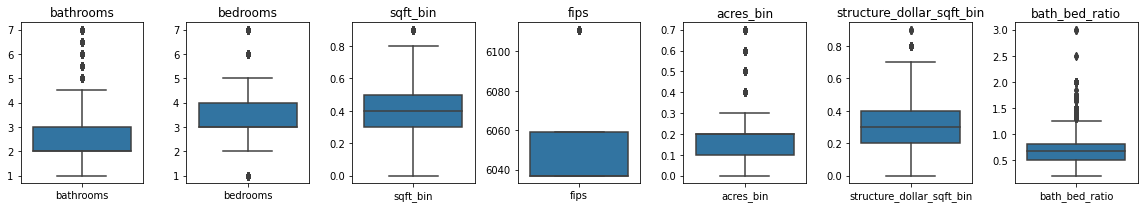

In [8]:
box_plot(df)

Now, we'll begin visualizing using the TRAIN dataframe. Comparing different features.

**Relationship Between Tax Value, Acres, Area, Price per sqft and FIPs**

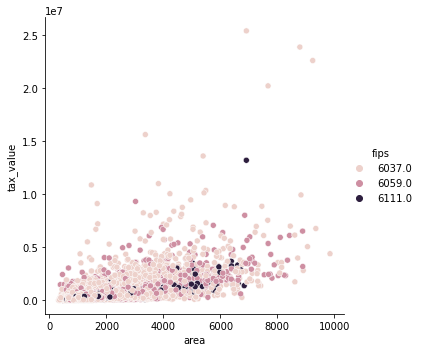

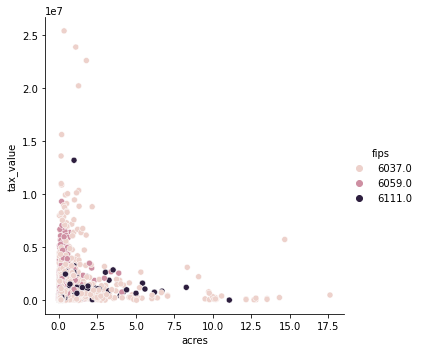

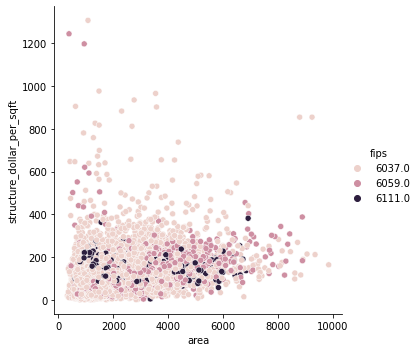

In [9]:
fips_relations(train)

- FIPs doesn't actually seem to have much of a sway over the other features, except price per sqft.

Let's check our categorical variables vs our target!

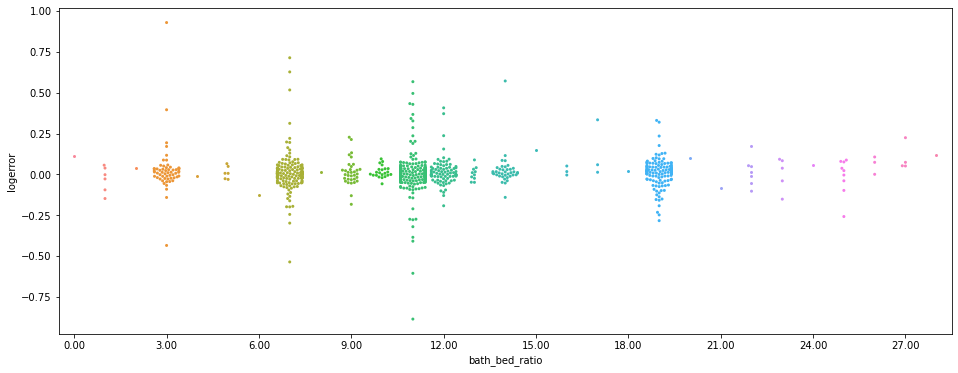

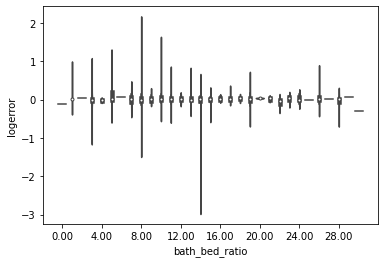

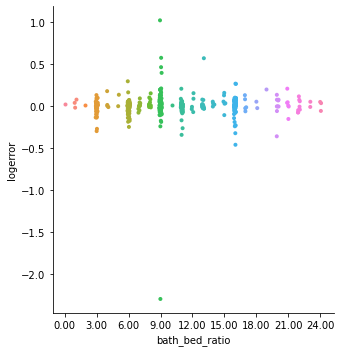

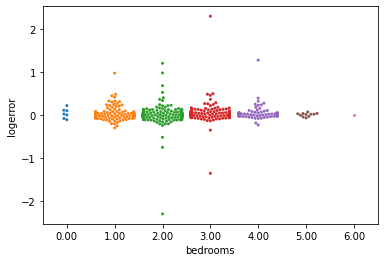

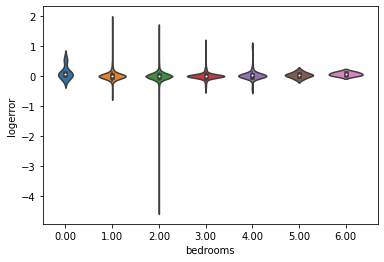

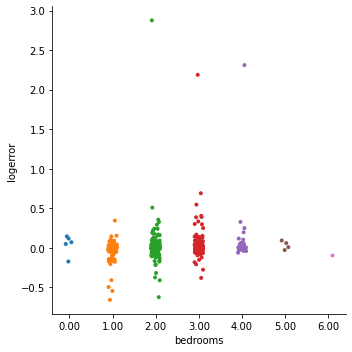

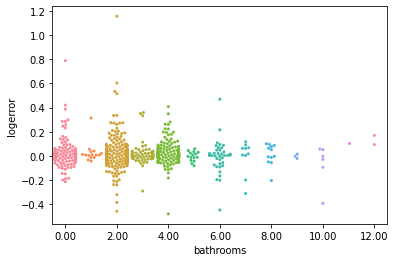

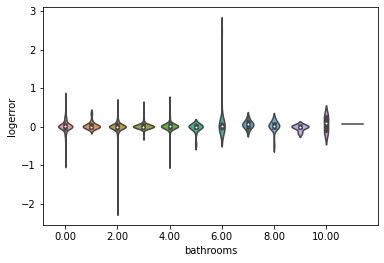

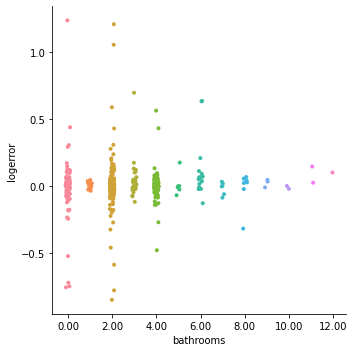

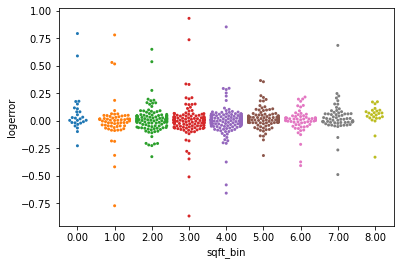

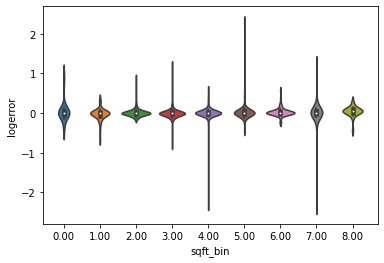

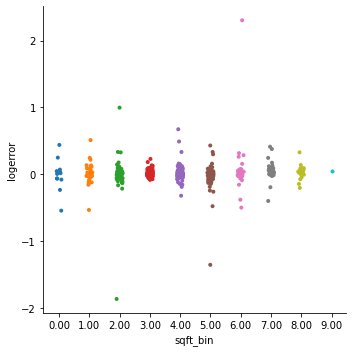

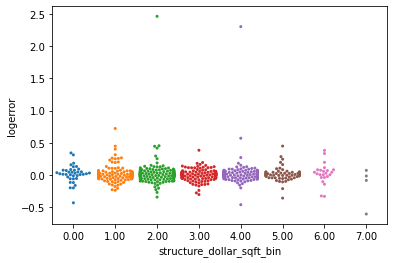

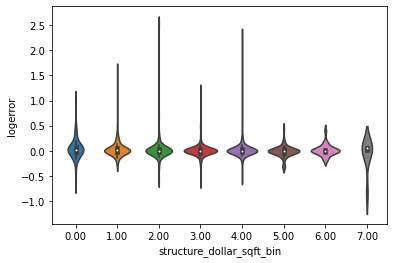

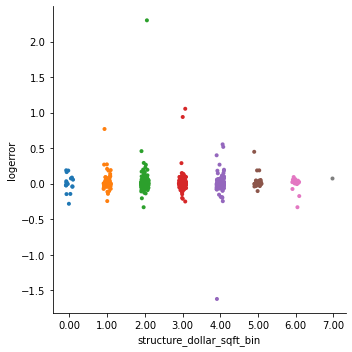

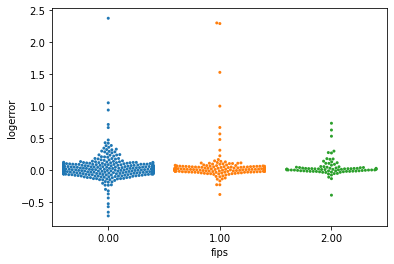

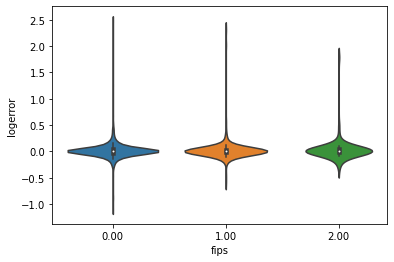

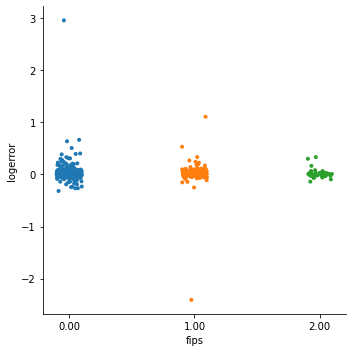

In [10]:
plot_categorical_and_continuous_vars(train, ['bath_bed_ratio', 'bedrooms', 'bathrooms', 'sqft_bin','structure_dollar_sqft_bin', 'fips'])

- We can see some of these variables have a wider spread for log error. We'll look further into how we might be able to minimize that using clustering, hopefully.

**Area, Acres and Log Error**

Let's also look into how Area and Acres relate to log error.

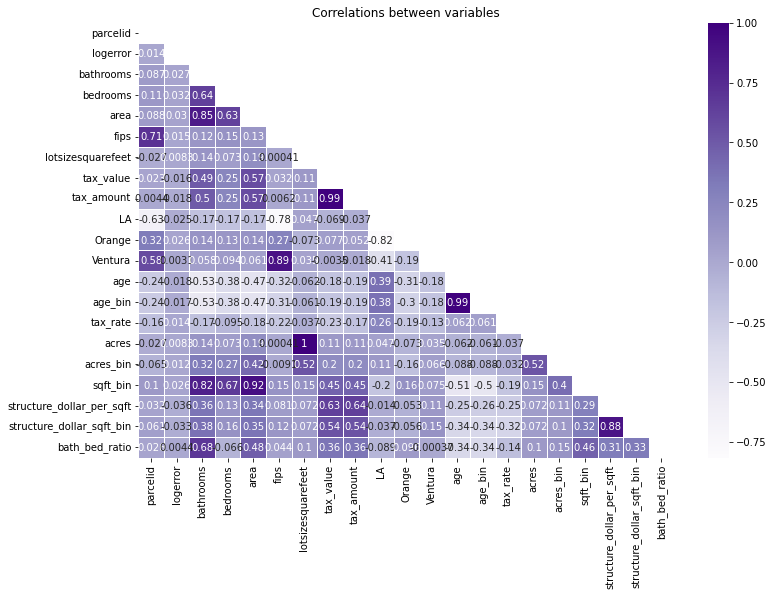

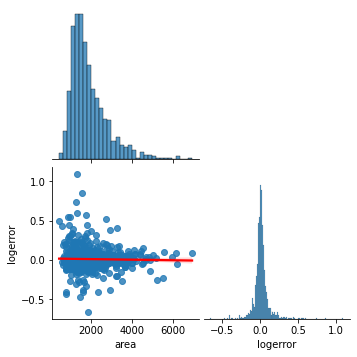

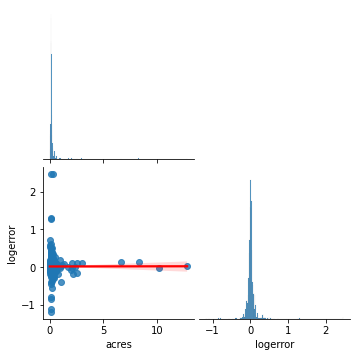

In [11]:
plot_variable_pairs(train)

It's difficult to find any sort of correlation with Log Error, so let's look at the bigger picture.

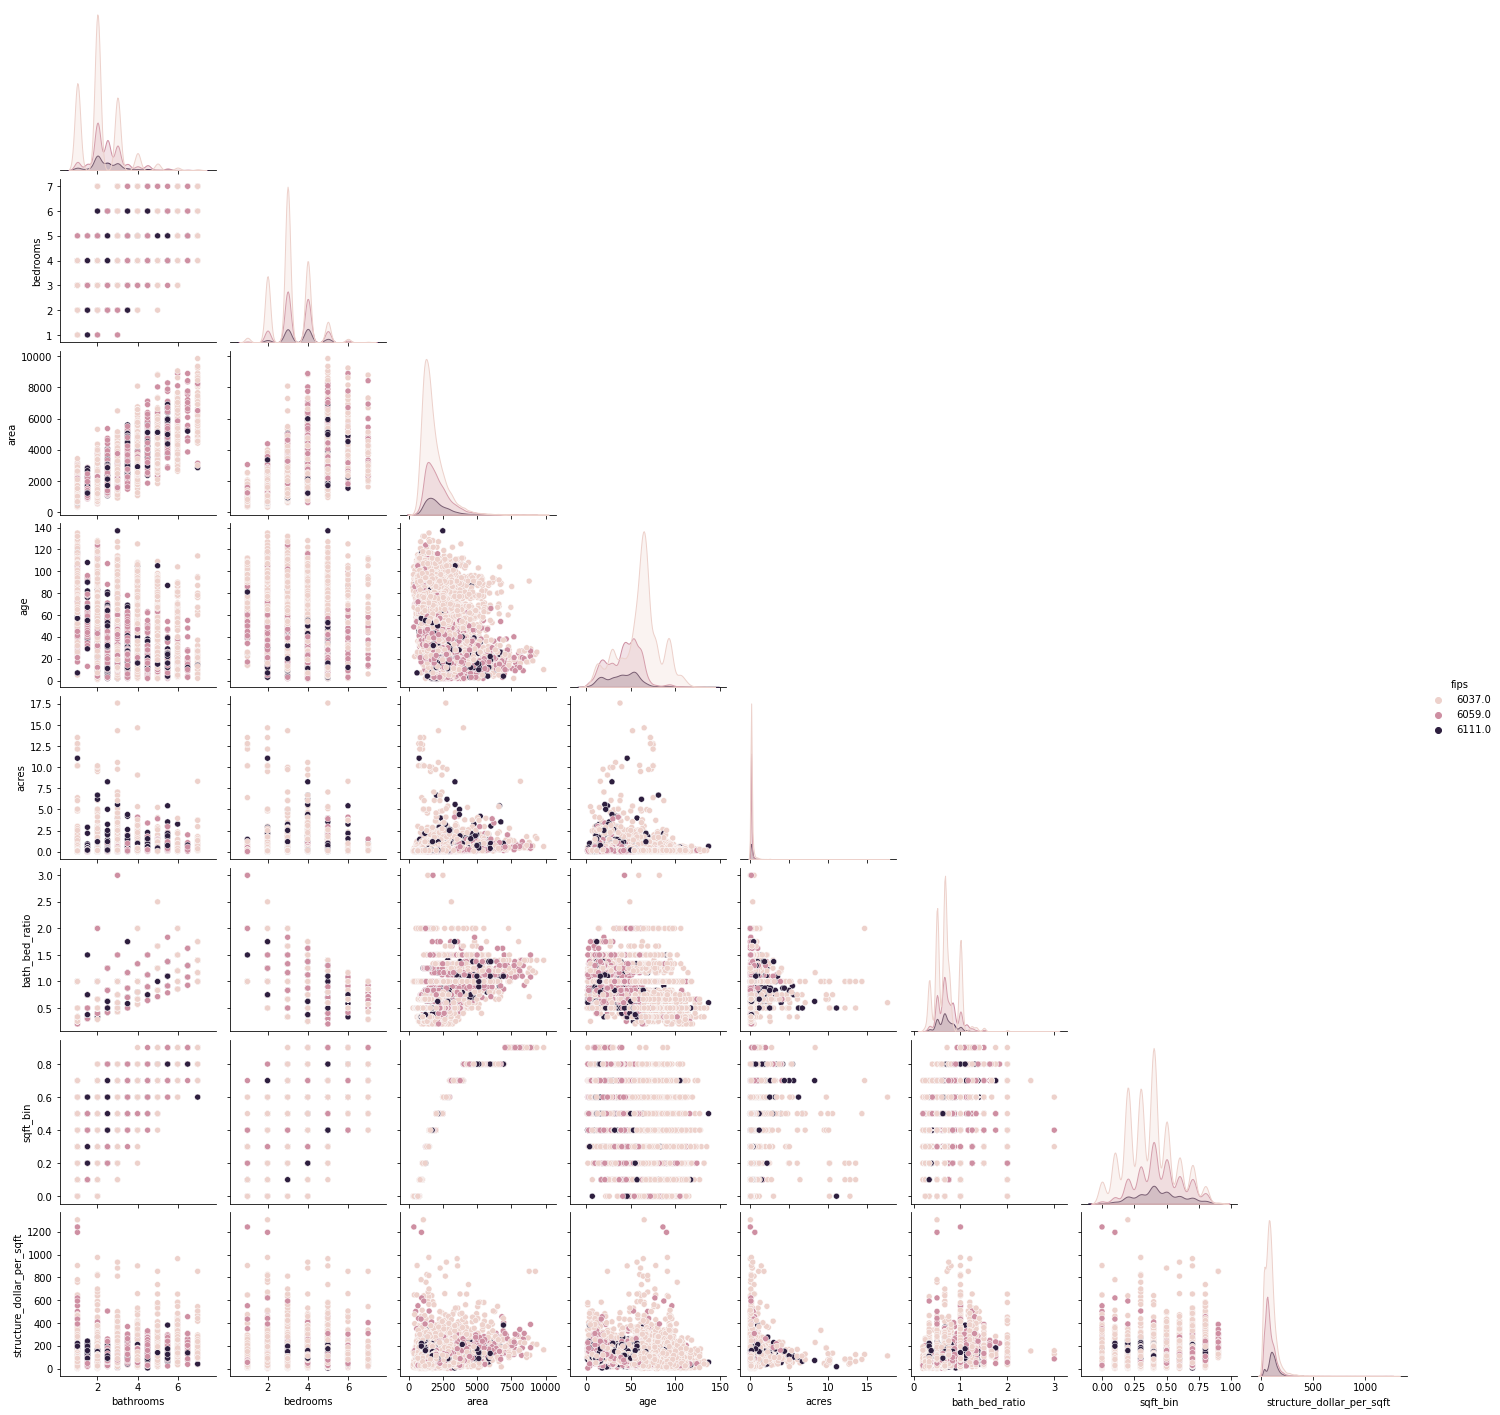

In [12]:
plot_df(train)

There's a few areas where you can see a bit of condensed values.

-----
### Creating some Clusters

We'll create some clusters, but we need to scale and split our scaled data first.

In [13]:
train_scaled, X_train_s, X_validate_s, X_test_s, y_train, y_validate, y_test = clean_and_split(scale(df))
train_scaled.shape, X_train_s.shape, X_validate_s.shape, X_test_s.shape, y_train.shape, y_validate.shape, y_test.shape

((28378, 21),
 (28378, 20),
 (12163, 20),
 (10136, 20),
 (28378, 1),
 (12163, 1),
 (10136, 1))

- Data Scaled then Cleaned and Split as previously done with the none scaled copy of the data. Shape is looking good still, and no nulls.

We'll start with the Price per sqft and area as a cluster since they're related to each other, the charts are difficult to pick out clusters on since there doesn't seem to be any clear ones we can located, so we'll check with elbow.

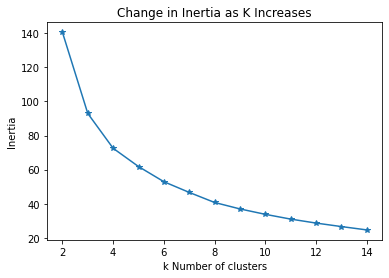

In [14]:
elbow(train_scaled, ["structure_dollar_per_sqft", "area"])

In [15]:
train['area_dollar_clusters'] = cluster(train_scaled, ['structure_dollar_per_sqft', 'area'])
X_validate_s['area_dollar_clusters'] = cluster(X_validate_s, ['structure_dollar_per_sqft', 'area'])
X_test_s['area_dollar_clusters'] = cluster(X_test_s, ['structure_dollar_per_sqft', 'area'])

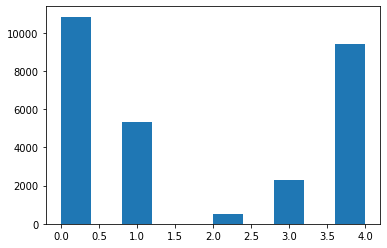

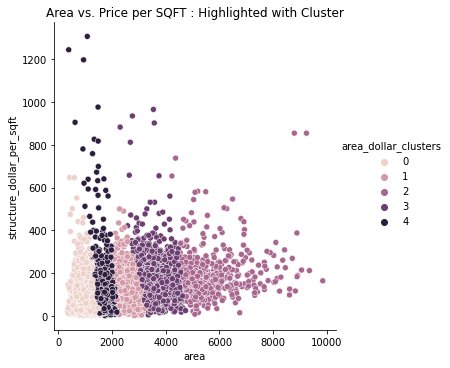

In [16]:
cluster_check_adc(train)

- They make some intereting clusters mainly using area, but also a bit of variance in price per sqft.

Let's include a cluster using Bedroooms, Bathrooms, and Area to cover the interior basics.

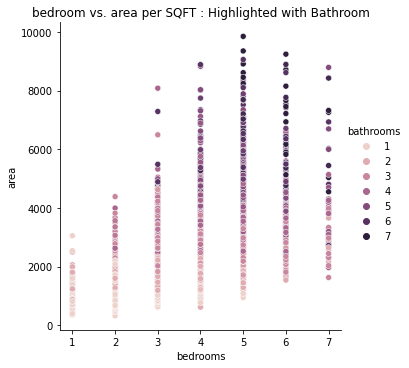

In [17]:
sns.relplot(data=train, 
            x="bedrooms",
            y="area", 
            hue = "bathrooms").set(
                title="bedroom vs. area per SQFT : Highlighted with Bathroom")
plt.show()

- There's some basic relations between them all, so the clusters should hopefully not sort by any one categorical value.

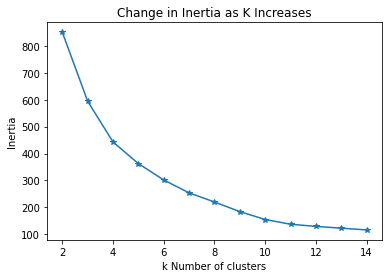

In [18]:
elbow(train_scaled, ['bedrooms', 'bathrooms','area'])

In [19]:
train['area_bedbath_clusters'] = cluster(train_scaled, ['bedrooms','bathrooms', 'area'], n_clusters=4)
X_validate_s['area_bedbath_clusters'] = cluster(X_validate_s, ['bedrooms','bathrooms', 'area'], n_clusters=4)
X_test_s['area_bedbath_clusters'] = cluster(X_test_s, ['bedrooms','bathrooms', 'area'], n_clusters=4)

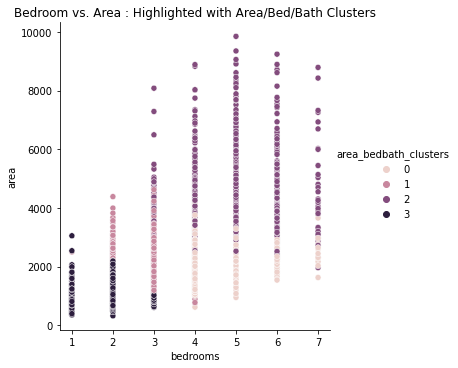

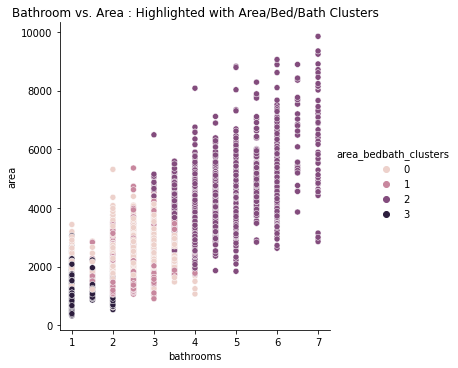

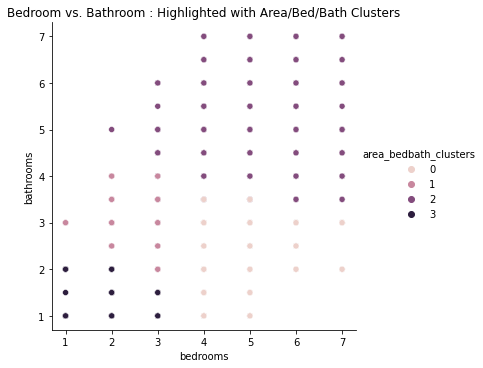

In [20]:
cluster_check_abbc(train)

- Thankfully, there does seem to be a bit of each variable taken into account, and it's created some intersting clusters: few bed/bath, few bed with many bath, many bed with few bath, and many of both, with them also sorted in similar style with area.

Previously bathrooms were established to have a larger affect on certain variables, so let's see how Bathrooms, Price per sqft, and Acreage would cluster together, giving a very general idea of interior size, price, and land size relation.

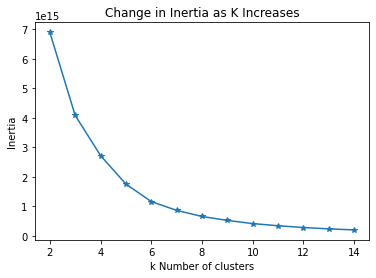

In [21]:
elbow(train_scaled, ['tax_value', 'bathrooms','acres'])

In [22]:
train['acre_bath_value'] = cluster(train_scaled, ['tax_value','bathrooms', 'acres'], n_clusters=6)
X_validate_s['acre_bath_value'] = cluster(X_validate_s, ['tax_value','bathrooms', 'acres'], n_clusters=6)
X_test_s['acre_bath_value'] = cluster(X_test_s, ['tax_value','bathrooms', 'acres'], n_clusters=6)

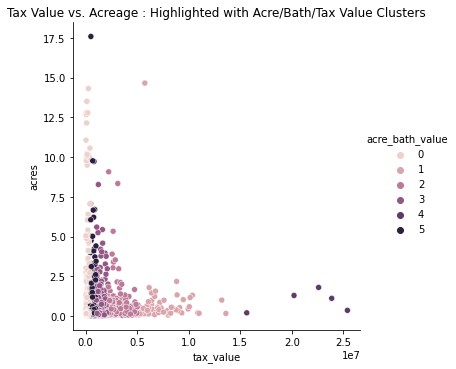

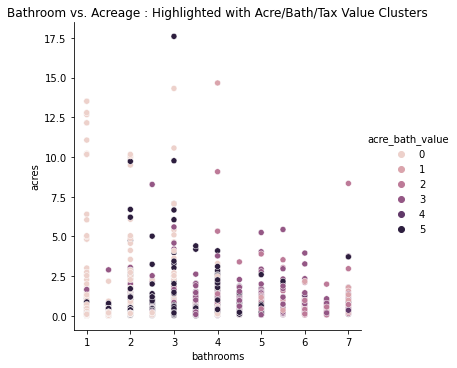

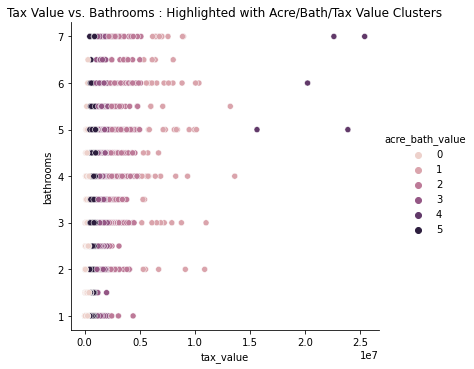

In [23]:
cluster_check_abv(train)

- Interesting distribution, mainly centered around Tax Value it seems.

Let's see how interior features like beds and bath along with exteior area, cluster with Value per sqft.

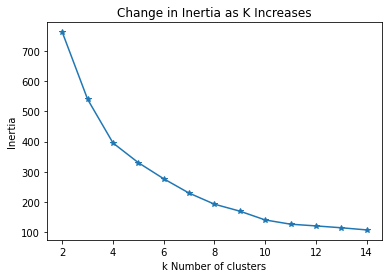

In [24]:
elbow(train_scaled, ['acres', 'bedrooms' , 'bathrooms','structure_dollar_per_sqft'])

In [25]:
train['areas_valuepsqft'] = cluster(train_scaled, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)
X_validate_s['areas_valuepsqft'] = cluster(X_validate_s, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)
X_test_s['areas_valuepsqft'] = cluster(X_test_s, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)

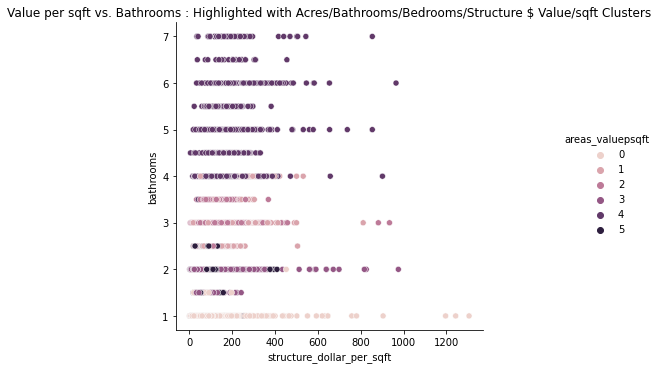

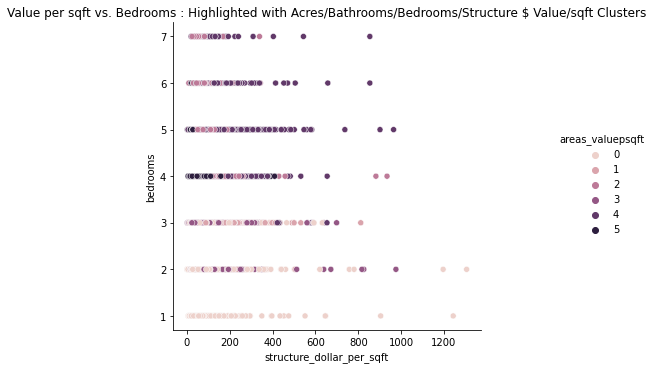

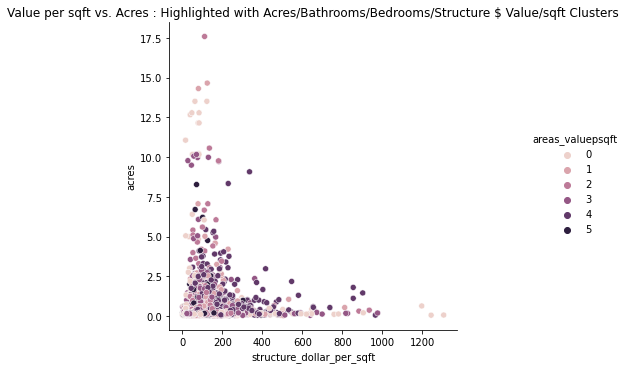

In [26]:
cluster_check_avc(train)

- A much more interesting cluster than the one before, it seems to be more of a mix of the various features in it.

------

### Stats Testing

------

### Modeling

Now that the clusters are ready, it is time to see what happens when they are trained and used to predict!

In [7]:
#initializing model functions and preparing data splits for modeling.
OLS = lm.LinearRegression()
LassoLars = lm.LassoLars(normalize = True)
lm2 = LinearRegression(normalize=True)
pf = PolynomialFeatures(degree=2)

NameError: name 'lm' is not defined

In [ ]:
# Establishing model baseline.
baseline = baseline_mean(y_validate, "logerror")
baseline

In [ ]:
# Adding clusters to the stratified data.
X_train_s['area_dollar_clusters'], X_train_s['area_bedbath_clusters'], X_train_s["acre_bath_value"], \
X_train_s["areas_valuepsqft"] = train['area_dollar_clusters'], train['area_bedbath_clusters'], train["acre_bath_value"], train["areas_valuepsqft"]
        
X_train_s = cluster_dummies(X_train_s)
X_validate_s = cluster_dummies(X_validate_s)
X_test_s = cluster_dummies(X_test_s)

In [ ]:
# OLS model
OLS.fit(X_train_s, y_train)
yhat_train = OLS.predict(X_train_s)
yhat = OLS.predict(X_validate_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

In [ ]:
# LassoLars model
LassoLars.fit(X_train_s, y_train)
yhat_train = LassoLars.predict(X_train_s)
yhat = LassoLars.predict(X_validate_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3)) 

In [ ]:
# Quadratic Polynomial Regression model
X_train_degree2 = pf.fit_transform(X_train_s)

X_validate_degree2 = pf.transform(X_validate_s)
X_test_degree2 = pf.transform(X_test_s)
validate_2 = pf.transform(X_validate_s)

lm2.fit(X_train_degree2, y_train)

yhat_train = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

So none of them are were useful, but the OLS model produced an intiguing negative r2_score. Because of this, it will move on to testing to see if this strange behavior can be captured in the testing data as well.

##### Final Model: OLS

Fitting the OLS to X,y train dataframe, and evaluating on X,y test.

In [ ]:
OLS.fit(X_train_s, y_train)
yhat_train = OLS.predict(X_train_s)
yhat = OLS.predict(X_test_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_test = mean_squared_error(y_test, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_test), 2))
print(round((r2_score(y_test, yhat)), 3))

### Conclusions

The testing data also proved to produce a negative r2_score. It is apparent that using features that are solely based in property value and size are actually detrimental to making clusters and therefore also detrimental to making predictions of logerror.

### Recommendations and Next Steps

More time is needed to further investigate ways to create feaures that focus heavily on location to aid in improving clusters. It would be the logical next step instead of hammering away at more features and clusters that use only monetary values. If real estate is a location game, then the modeling should try to reflect that more.

Also, more methods and machine learning algorithms may turn out to be more beneficial for these types of problems. It would be worth looking into them if linear regression, even with clustering, is not an efficient or effective route to predicting logerror.